# Getting the most out of linear convergence with Aitken's method

In this notebook we will see how to accelerate linearly convergent iterations via Aitken's acceleration

See Chapter 19 of 

*Q. Kong, T. Siauw, and A. M. Bayen. Python Programming and Numerical Methods: A Guide for Engineers and Scientists. Academic Press, 2021. (https://pythonnumericalmethods.berkeley.edu/)*

and Sections 2.4 and 2.5 of 

*Richard L. Burden, J. Douglas Faires and Annette M. Burden. Numerical Analysis (10th Edition). Cengage, 2016.*

## Import libraries and define auxiliary functions

In [1]:
# Import libraries and define auxiliary functions
import math
import numpy as np
import matplotlib.pyplot as plt

def fixed_point(g, p0, TOL, N_max):
    """
    Approximates the solution to a fixed-point equation g(x) = x via the fixed-point method 
    using p0 as initial guess, N_max maximum iterations, a tolerance criterion on the relative increment
    with parameter TOL (i.e., method stops when |p_n - p_{n-1}|/|p_n| <= TOL).

    The function returns an array containing the sequence of approximations computed by the method.
    """
    
    n = 0  # initialize iteration counter
    p = p0 # initialize current approximation 
    rel_increment = np.inf # initialize relative increment to enter the while loop
    p_array = np.array(p).reshape(1,1)  # initialize array of approximations
    
    while (n < N_max and rel_increment > TOL):
        n = n + 1 # increase iteration counter
        p = g(p)  # apply g 
        rel_increment = np.abs(p - p_array[-1]) / np.abs(p) # update relative increment
        p_array = np.vstack((p_array, p)) # add current approximation to array

    # maximum number of iterations reached, but return the array of approximations anyways
    return p_array 

def newton(f, Df, p0, TOL, N_max):
    """
    Finds a root of f(x) using Netwon's method with p0 as initial guess, N_max maximum iterations, 
    a tolerance criterion on the relative increment with parameter TOL (i.e., method stops when 
    |p_n - p_{n-1}|/|p_n| <= TOL). This function requires the derivative of f as input as well.

    The function returns an array containing the sequence of approximations computed by the method.
    """
    
    n = 0  # initialize iteration counter
    p = p0 # initialize current approximation 
    rel_increment = np.inf # initialize relative increment to enter the while loop
    p_array = np.array(p).reshape(1,1)  # initialize array of approximations
    
    while (n < N_max and rel_increment > TOL):
        n = n + 1 # increase iteration counter
        if Df(p) == 0: # Make sure that we can divide by f'(p)
            raise TypeError("Derivative of f vanishes. Newton's iteration is not well defined.")
        p = p - f(p)/Df(p)  # Newton's iteration 
        rel_increment = np.abs(p - p_array[-1]) / np.abs(p) # update relative increment
        p_array = np.vstack((p_array, p)) # add current approximation to array

    # maximum number of iterations reached, but return the array of approximations anyways
    return p_array 

## Linearly convergent iterations

Recall that a sequence $(p_n)_{n=1}^{\infty}$ converges linearly to $p$ if
$$
\lim_{n \to \infty} \frac{|p_{n+1} - p|}{|p_n -p|} = \lambda < 1.
$$
For example, the fixed-point iteration applied to $g(x) = \cos(x)$ with $p_0 = 1$ is linearly convergent.

In [2]:
# Generate fixed point sequence p_{n+1} = cos(p_n)
g = lambda x: np.cos(x)
p0 = 1
TOL = 1e-8
N_max = 100
p_array = fixed_point(g, p0, TOL, N_max)

We check linear convergence by computing an approximation to the root $p$ of $f(x) = \cos(x) - x$ using Netwon's method and using such $p$ as our ground truth.

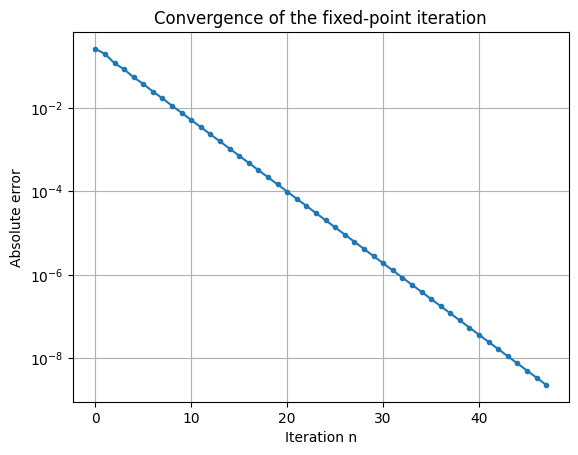

In [3]:
# Compute a very good approximation of the ground truth p using Newton's method 
# with the last computed element of the sequence as initial guess
f  = lambda x : np.cos(x) - x
Df = lambda x : -np.sin(x) - 1
TOL = 1e-10
N_max = 50
p0 = p_array[-1]
p_array_newton = newton(f, Df, p0, TOL, N_max)
p = p_array_newton[-1]

# Generate arrays of iteration values
n_values = np.arange(p_array.size) 

# Create convergence plot
plt.semilogy(n_values, np.abs(p_array - p), '.-')
plt.xlabel("Iteration n")
plt.ylabel("Absolute error")
plt.title("Convergence of the fixed-point iteration")
plt.grid()
plt.show()

We can visualize the definition of linear convergence by showing that the ratio $|p_{n+1}-p|/|p_n - p|$ numerically tends to a value $\lambda < 1$.

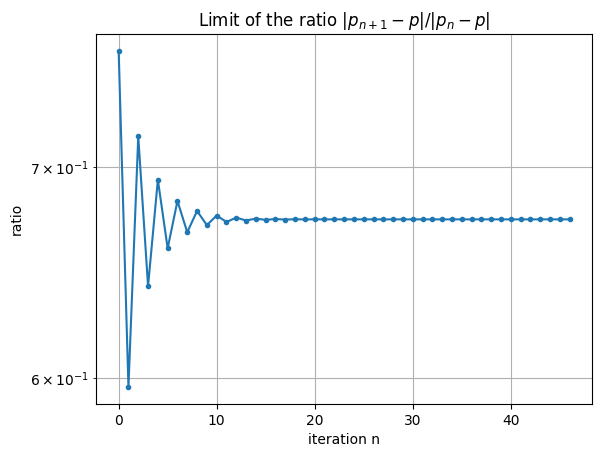

In [4]:
# Numerical computation of the limit value lambda
ratio_array = np.abs(p_array[1:] - p)/np.abs(p_array[:-1] - p)
n_values_ratio = np.arange(ratio_array.size)

plt.semilogy(n_values_ratio,ratio_array, '.-')
plt.xlabel("iteration n")
plt.ylabel("ratio")
plt.title("Limit of the ratio $|p_{n+1}-p|/|p_n - p|$")
plt.grid(which = 'both')
plt.show()

The value of $\lambda$ is approximately

In [5]:
print(ratio_array[-1])

[0.67361206]


## Aitken's acceleration

We now implement and test Aitken's acceleration.

In [6]:
def Aitken(p):
    """
    Given a sequence (p_n), outputs the sequence (a_n) generated by Aitken's acceleration, defined by

    a_n = p_n - (Delta p_n)^2 / Delta^2 p_n,

    where Delta p_n = p_(n+1) - p_n and Delta^2 p_n = p_(n+2) - 2 p_(n+1) + p_n.

    Note that p should be a NumPy array. If p has n entries, a will have n-2 entries 
    """
    Delta_p = np.diff(p, axis = 0)
    Delta2_p = np.diff(Delta_p, axis = 0)
    a = p[:-2] - Delta_p[:-1]**2 / Delta2_p
    
    return a

Apply Aitken's acceleration to the previously generated sequence.

In [7]:
p_aitken_array = Aitken(p_array)

Compare the convergence of the original sequence vs. the accelerated sequence. Aitken's convergence is still linear, but visibly faster.

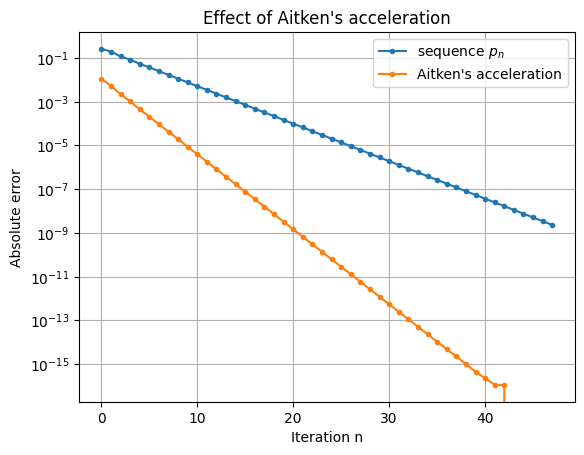

In [8]:
# Generate arrays of iteration values
n_values_aitken = np.arange(p_aitken_array.size) 

# show convergence plots
plt.semilogy(n_values, np.abs(p_array - p), '.-', label = 'sequence $p_n$')
plt.semilogy(n_values_aitken, np.abs(p_aitken_array - p), '.-', label = 'Aitken\'s acceleration')
plt.xlabel("Iteration n")
plt.ylabel("Absolute error")
plt.title("Effect of Aitken\'s acceleration")
plt.legend()
plt.grid()
plt.show()

## Steffensen's method

Note that in the previous example we first computed the sequence $p_n$ and then applied Aitken's acceleration to it. A more practical approach is to directly combine the computation of the fixed-point sequence with acceleration. This is done via Steffensen's method, which alternates two fixed-point iteration steps with one step of Aitken's acceleration step based on the three previous sequence values.


Let $p_0^{(0)} = p_0$ and
\begin{align*}
&p_0^{(0)} = p_0 \text{ (fixed)}, 
\qquad \qquad \qquad \;\; \;
p_1^{(0)} = g(p_0^{(0)}), \quad p_2^{(0)} = g(p_1^{(0)}), \\
& p_0^{(1)} = \hat{p}_0^{(0)} = p_0^{(0)} - \frac{(\Delta p_0^{(0)})^2}{\Delta^2 p_0^{(0)}}, 
\quad p_1^{(1)} = g(p_0^{(1)}), \quad p_2^{(1)} = g(p_1^{(1)})\\
& p_0^{(2)} = \hat{p}_0^{(1)} = p_0^{(1)} - \frac{(\Delta p_0^{(1)})^2}{\Delta^2 p_0^{(1)}}, \quad   \ldots
\end{align*}
In the notation above, the $\Delta$ operator applies to the subscript index, i.e.
$$
{p}^{(k+1)}_0 = \hat{p}^{(k)}_0 = p^{(k)}_0 - \frac{(p^{(k)}_{1}-p^{(k)}_{0})^2}{p^{(k)}_{2}- 2 p^{(k)}_{1} + p^{(k)}_0}
$$




## Recommended problems
1. Test Aitken's acceleration to other linearly convergent sequences
2. What happens if you apply Aitken's acceleration to a superlinearly convergent sequence?
3. Implement and test Steffensen's method on the example presented in this notebook